THE BELOW IS GEMINI CODE

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose


from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Activation 
from tensorflow.keras.layers import BatchNormalization 


from tensorflow.keras.datasets import cifar10


import tensorflow.keras.backend as K


from tensorflow.keras.optimizers.schedules import CosineDecay


print("\nAll libraries for 'Asymmetric ResNet' (Iter. 13) are imported.")

2025-11-10 16:18:56.539067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762791536.781141      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762791536.850705      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


All libraries for 'Asymmetric ResNet' (Iter. 13) are imported.


In [ ]:



channel = 128         
epochs = 15000       
batch_size = 128      


new_tx_lr = 1e-4       
new_rx_lr = 5e-5       


sigma_sq = 5e-4        
UWA_TAPS = np.array([1.0])  


joint_epochs = 10000    
fine_tune_epochs = 5000 
ssim_weight = 0.2       
anneal_factor = 0.95    

clipnorm_tx = 1.0       
clipnorm_rx = 1.0       
min_sigma_sq = 1e-4     
-
print("\n--- Parameters Set for 'Asymmetric' (Shallow Tx + Deep Rx) JSCC Experiment ---")
print(f"Channel Capacity (k):          {channel}")
print(f"Total Epochs:                  {epochs}  (Joint={joint_epochs}, Fine-tune={fine_tune_epochs})")
print(f"Batch Size:                    {batch_size}")
print(f"Learning Rate (Tx initial):    {new_tx_lr}")
print(f"Learning Rate (Rx):            {new_rx_lr}")
print(f"Noise Variance (sigma_sq):     {sigma_sq}")
print(f"SSIM Fine-tune Weight:         {ssim_weight}")
print(f"Noise Annealing Factor:        {anneal_factor}")
print(f"Channel Model:                 AWGN (UWA_TAPS={UWA_TAPS})")
print(f"Gradient Clipnorms:            Tx={clipnorm_tx}, Rx={clipnorm_rx}")
print("---------------------------------------------------------------------")



--- Parameters Set for 'Asymmetric' (Shallow Tx + Deep Rx) JSCC Experiment ---
Channel Capacity (k):          128
Total Epochs:                  15000  (Joint=10000, Fine-tune=5000)
Batch Size:                    128
Learning Rate (Tx initial):    0.0001
Learning Rate (Rx):            5e-05
Noise Variance (sigma_sq):     0.0005
SSIM Fine-tune Weight:         0.2
Noise Annealing Factor:        0.95
Channel Model:                 AWGN (UWA_TAPS=[1.])
Gradient Clipnorms:            Tx=1.0, Rx=1.0
---------------------------------------------------------------------


In [ ]:
print("Loading CIFAR-10 dataset...")
(image_dataset_0_255, _), (_, _) = cifar10.load_data()


image_dataset_norm = image_dataset_0_255 / 255.0

print(f"Dataset loaded. Shape: {image_dataset_norm.shape}")
print(f"Pixel range: {np.min(image_dataset_norm)} to {np.max(image_dataset_norm)}")

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Dataset loaded. Shape: (50000, 32, 32, 3)
Pixel range: 0.0 to 1.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Flatten, Dense, Reshape, Lambda,
    Concatenate, Conv2DTranspose, Add, Activation,
    PReLU, BatchNormalization
)
from tensorflow.keras import backend as K
import keras
import numpy as np
from tensorflow.keras.optimizers.schedules import CosineDecay


class GDN(tf.keras.layers.Layer):
    def __init__(self, inverse=False, beta_min=1e-6, gamma_init=0.1, **kwargs):
        super(GDN, self).__init__(**kwargs)
        self.inverse = inverse
        self.beta_min = beta_min
        self.gamma_init = gamma_init

    def build(self, input_shape):
        channels = int(input_shape[-1])
        self.beta = self.add_weight(
            name="beta",
            shape=(channels,),
            initializer=tf.keras.initializers.Constant(1.0),
            trainable=True,
        )
        self.gamma = self.add_weight(
            name="gamma",
            shape=(channels, channels),
            initializer=tf.keras.initializers.Identity(gain=self.gamma_init),
            trainable=True,
        )
        super(GDN, self).build(input_shape)

    def call(self, x):
        beta = tf.maximum(self.beta, self.beta_min)
        gamma = tf.square(self.gamma)
        kernel = tf.reshape(gamma, [1, 1, x.shape[-1], x.shape[-1]])
        norm = tf.sqrt(
            tf.nn.conv2d(tf.square(x), kernel, strides=[1, 1, 1, 1], padding="SAME") + beta
        )
        return x * norm if self.inverse else x / norm



print(f"--- Setting up Schedulers & Helpers ---")
steps_per_epoch = 500
decay_steps = max(1, int(epochs * steps_per_epoch // 4))
lr_schedule = CosineDecay(initial_learning_rate=new_tx_lr, decay_steps=decay_steps, alpha=0.0)


def perturbation(x):
    stddev = tf.cast(tf.math.sqrt(sigma_sq), tf.float32)
    w = K.random_normal(shape=K.shape(x), mean=0.0, stddev=stddev)
    multiplier = tf.cast(tf.math.sqrt(1 - sigma_sq), tf.float32)
    return multiplier * x + w

def loss_tx(y_true_loss, y_pred_policy):
    reward = y_true_loss - tf.reduce_mean(y_true_loss)
    return -reward * y_pred_policy + 1e-8  

def get_policy(inp):
    xp, x = inp
    w = xp - x
    denom = tf.cast(2 * sigma_sq, tf.float32)
    return -K.sum(w * w, axis=[1, 2]) / denom

def channel_uwa(x_batch, taps, noise_std):
    y_batch = []
    for x in x_batch:
        noise = np.random.normal(0, noise_std, x.shape)
        y_batch.append(x + noise)
    return np.array(y_batch).astype("float32")


def paper_loss(y_true, y_pred):
    x_initial, x_final = y_pred
    l_init = tf.reduce_mean(tf.square(y_true - x_initial))
    l_final = tf.reduce_mean(tf.square(y_true - x_final))
    return l_init + l_final

def paper_loss_per_item(y_true, y_pred):
    x_final = y_pred[1]
    return tf.reduce_mean(tf.square(y_true - x_final), axis=(1, 2, 3))


def perceptual_loss(y_true, y_pred):
    """Perceptual fine-tune loss = MSE + 0.2 × (1 - SSIM)."""
    x_initial, x_final = y_pred
    mse = tf.reduce_mean(tf.square(y_true - x_final))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, x_final, max_val=1.0))
    return mse + 0.2 * ssim_loss

print("--- Helper functions defined successfully ---")



print("Building *SHALLOW* Transmitter (Encoder)...")

total_channel = channel
lf_channel = 16
hf_channel = total_channel - lf_channel

tx_inp = Input(shape=(32, 32, 3))
x_enc = Conv2D(64, (5, 5), padding="same", strides=2)(tx_inp)
x_enc = GDN(inverse=False)(x_enc)
x_enc = PReLU(shared_axes=[1, 2])(x_enc)

x_enc = Conv2D(32, (5, 5), padding="same", strides=2)(x_enc)
x_enc = GDN(inverse=False)(x_enc)
x_enc = PReLU(shared_axes=[1, 2])(x_enc)

hf_flat = Flatten()(x_enc)
hf_dense = Dense(2 * hf_channel, activation="relu")(hf_flat)
hf_signal = Reshape((hf_channel, 2))(hf_dense)

lf_enc = Conv2D(16, (5, 5), padding="same", strides=2)(x_enc)
lf_enc = GDN(inverse=False)(lf_enc)
lf_enc = PReLU(shared_axes=[1, 2])(lf_enc)
lf_flat = Flatten()(lf_enc)
lf_dense = Dense(2 * lf_channel, activation="relu")(lf_flat)
lf_signal = Reshape((lf_channel, 2))(lf_dense)

to_complex = Concatenate(axis=1)([lf_signal, hf_signal])
x = Lambda(lambda z: K.l2_normalize(z, axis=-1))(to_complex)
xp = Lambda(perturbation)(x)
policy = Lambda(get_policy)([xp, x])

model_policy = keras.models.Model(inputs=tx_inp, outputs=policy, name="Policy_Model")
model_tx = keras.models.Model(inputs=tx_inp, outputs=xp, name="Signal_Tx_Model")
model_x = keras.models.Model(inputs=tx_inp, outputs=x, name="Clean_Signal_Model")

print(model_policy.summary())



def residual_block(x, filters, kernel_size=(3, 3), strides=1):
    shortcut = x
    if strides > 1 or x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)
    y = Conv2D(filters, kernel_size, strides=strides, padding="same")(x)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(filters, kernel_size, padding="same")(y)
    y = BatchNormalization()(y)
    y = Add()([shortcut, y])
    return Activation("relu")(y)

def build_receiver_asymmetric(total_channel_in, lf_channel_in):
    hf_channel_in = total_channel_in - lf_channel_in
    print("Building *DEEP* Asymmetric Receiver (Decoder + ResNet Refinement)...")
    rx_inp = Input(shape=(total_channel_in, 2))

    lf_signal_in = Lambda(lambda z: z[:, :lf_channel_in, :])(rx_inp)
    lf_flat_in = Flatten()(lf_signal_in)
    hf_signal_in = Lambda(lambda z: z[:, lf_channel_in:, :])(rx_inp)
    hf_flat_in = Flatten()(hf_signal_in)

    lf_dense_in = Dense(4 * 4 * 16, activation="relu")(lf_flat_in)
    lf_unflat = Reshape((4, 4, 16))(lf_dense_in)
    lf_up = Conv2DTranspose(32, (5, 5), strides=2, padding="same")(lf_unflat)
    lf_up = GDN(inverse=True)(lf_up)
    lf_up = PReLU(shared_axes=[1, 2])(lf_up)

    hf_dense_in = Dense(8 * 8 * 32, activation="relu")(hf_flat_in)
    hf_unflat = Reshape((8, 8, 32))(hf_dense_in)

    combined_decode = Concatenate()([lf_up, hf_unflat])
    x_dec = Conv2D(64, (5, 5), padding="same")(combined_decode)
    x_dec = GDN(inverse=True)(x_dec)
    x_dec = PReLU(shared_axes=[1, 2])(x_dec)

    x_dec = Conv2DTranspose(32, (5, 5), strides=2, padding="same")(x_dec)
    x_dec = GDN(inverse=True)(x_dec)
    x_dec = PReLU(shared_axes=[1, 2])(x_dec)

    x_dec = Conv2DTranspose(16, (5, 5), strides=2, padding="same")(x_dec)
    x_dec = GDN(inverse=True)(x_dec)
    x_dec = PReLU(shared_axes=[1, 2])(x_dec)

    
    x_initial = Conv2D(3, (5, 5), activation="sigmoid", padding="same", name="initial_output")(x_dec)

   
    x_res = residual_block(x_initial, 64)
    x_res = residual_block(x_res, 64)
    x_res = residual_block(x_res, 64)

    x_correction = Conv2D(3, (3, 3), activation="tanh", padding="same")(x_res)
    x_final = Add(name="final_output")([x_initial, x_correction])
    x_final = Lambda(lambda z: K.clip(z, 0.0, 1.0))(x_final)

    return keras.models.Model(inputs=rx_inp, outputs=[x_initial, x_final], name="Receiver_Model")

model_receiver = build_receiver_asymmetric(total_channel, lf_channel)
print(model_receiver.summary())



print("--- Compiling models with stability and perceptual support ---")
optimizer_tx = tf.keras.optimizers.SGD(learning_rate=lr_schedule, clipnorm=1.0)
optimizer_rx = tf.keras.optimizers.Adam(learning_rate=new_rx_lr, clipnorm=1.0)

model_policy.compile(loss=loss_tx, optimizer=optimizer_tx)


print("\n--- Asymmetric Receiver built successfully (loss assigned during training loop) ---")
print("--- All models initialized and ready. ---")


--- Setting up Schedulers & Helpers ---
--- Helper functions defined successfully ---
Building *SHALLOW* Transmitter (Encoder)...


I0000 00:00:1762791605.340931      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "Policy_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      4,864 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn (GDN)           │ (None, 16, 16,    │      4,160 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 16, 16,    │         64 │ gdn[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 32)  │     51,232 │ p_re_lu[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_1 (GDN)         │ (None, 8, 8, 32)  │      1,056 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 8, 8, 32)  │         32 │ gdn_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 16)  │     12,816 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_2 (GDN)         │ (None, 4, 4, 16)  │        272 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 4, 4, 16)  │         16 │ gdn_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ p_re_lu_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ p_re_lu_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      8,224 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 224)       │    458,976 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 16, 2)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 112, 2)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 2)    │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 2)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 2)    │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None)            │          0 │ lambda_1[0][0],   │
│                     │                   │            │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 541,712 (2.07 MB)

 Trainable params: 541,712 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Building *DEEP* Asymmetric Receiver (Decoder + ResNet Refinement)...


Model: "Receiver_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 16, 2)     │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │      8,448 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 4, 4, 16)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 112, 2)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 32)  │     12,832 │ reshape_2[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 224)       │          0 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_3 (GDN)         │ (None, 8, 8, 32)  │      1,056 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │    460,800 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 8, 8, 32)  │         32 │ gdn_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 8, 8, 32)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 64)  │          0 │ p_re_lu_3[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │    102,464 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_4 (GDN)         │ (None, 8, 8, 64)  │      4,160 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 8, 8, 64)  │         64 │ gdn_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │     51,232 │ p_re_lu_4[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_5 (GDN)         │ (None, 16, 16,    │      1,056 │ conv2d_transpose… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 16, 16,    │         32 │ gdn_5[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │     12,816 │ p_re_lu_5[0][0]   │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gdn_6 (GDN)         │ (None, 32, 32,    │        272 │ conv2d_transpose… │
│                     │ 16)               │            │                 

 Total params: 846,694 (3.23 MB)

 Trainable params: 845,798 (3.23 MB)

 Non-trainable params: 896 (3.50 KB)

None
--- Compiling models with stability and perceptual support ---

--- Asymmetric Receiver built successfully (loss assigned during training loop) ---
--- All models initialized and ready. ---


In [ ]:
import tensorflow as tf
import numpy as np
import time
import csv


GLOBAL_BATCH_SIZE = batch_size
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")

image_dataset_norm = image_dataset_norm.astype('float32') 
train_dataset = tf.data.Dataset.from_tensor_slices(image_dataset_norm)
train_dataset = train_dataset.shuffle(50000).batch(GLOBAL_BATCH_SIZE).repeat() 
train_iterator = iter(train_dataset)


@tf.function
def tf_channel_uwa(x_batch, sigma):
    """TensorFlow wrapper for numpy-based underwater channel with dynamic noise."""
    output_shape = x_batch.shape
    y_batch = tf.py_function(
        func=channel_uwa, 
        inp=[x_batch, UWA_TAPS, sigma],  
        Tout=tf.float32
    )
    y_batch.set_shape(output_shape)
    return y_batch



def perceptual_loss(y_true, y_pred):
    """Perceptual loss = MSE + 0.2 * (1 - SSIM)."""
    x_initial, x_final = y_pred
    mse = tf.reduce_mean(tf.square(y_true - x_final))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, x_final, max_val=1.0))
    return mse + 0.2 * ssim_loss



@tf.function
def train_rx_step(batch_images, sigma, use_perceptual=False):
    """Receiver training step. If use_perceptual=True, applies MSE+SSIM loss."""
    clean_signal = model_x(batch_images, training=False)
    y_rx = tf_channel_uwa(clean_signal, sigma)
    
    with tf.GradientTape() as tape:
        pred_images_list = model_receiver(y_rx, training=True)
        
        if use_perceptual:
            loss = perceptual_loss(batch_images, pred_images_list)
        else:
            loss = paper_loss(batch_images, pred_images_list)

    grads = tape.gradient(loss, model_receiver.trainable_variables)
    optimizer_rx.apply_gradients(zip(grads, model_receiver.trainable_variables))
    
    initial_loss = tf.reduce_mean(tf.square(batch_images - pred_images_list[0]))
    final_loss = tf.reduce_mean(tf.square(batch_images - pred_images_list[1]))
    return initial_loss, final_loss


@tf.function
def train_tx_step(batch_images, sigma):
    """Transmitter policy training step."""
    xp = model_tx(batch_images, training=False)
    y_tx = tf_channel_uwa(xp, sigma)
    pred_images_list = model_receiver(y_tx, training=False)
    loss_per_item = paper_loss_per_item(batch_images, pred_images_list)

    with tf.GradientTape() as tape:
        policy = model_policy(batch_images, training=True)
        loss = loss_tx(loss_per_item, policy)
        avg_loss = tf.reduce_mean(loss)
        avg_loss += 0.0 * tf.reduce_sum([tf.reduce_sum(v) for v in model_policy.trainable_variables])

    grads = tape.gradient(avg_loss, model_policy.trainable_variables)

    if grads is not None:
        valid_grads_and_vars = [
            (g, v) for g, v in zip(grads, model_policy.trainable_variables) if g is not None
        ]
        if valid_grads_and_vars:
            optimizer_tx.apply_gradients(valid_grads_and_vars)

    return tf.reduce_mean(loss_per_item)



print("\n--- Starting Asymmetric JSCC Training (Tx+Rx joint, then Rx-only with perceptual fine-tune) ---")

loss_tx_history, loss_rx_history, loss_rx_final_history = [], [], []
log_csv_path = "/kaggle/working/training_log.csv"

csv_file = open(log_csv_path, 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["Epoch", "Tx_Score", "Rx_Loss_Initial", "Rx_Loss_Final", "Phase"])

joint_epochs = 10000
fine_tune_epochs = 5000  
sigma_sq_anneal = sigma_sq  

for epoch in range(joint_epochs + fine_tune_epochs):
    try:
        if epoch == joint_epochs:
            print("\n================= PHASE 2: RECEIVER-ONLY FINE-TUNE =================")
            model_tx.trainable = False
            model_policy.trainable = False
            sigma_sq_anneal = 5e-4
            fine_tune_lr = 5e-5
            optimizer_rx.learning_rate.assign(fine_tune_lr)
            print(f"→ Tx frozen, Rx fine-tune started with LR={fine_tune_lr}, σ²={sigma_sq_anneal}")

        cur_sigma = np.sqrt(sigma_sq_anneal).astype('float32')

        if epoch < joint_epochs:
            phase = "Joint"
            tx_batch = next(train_iterator)
            tx_score_val = train_tx_step(tx_batch, cur_sigma)
            rx_batch = next(train_iterator)
            rx_loss_initial_val, rx_loss_final_val = train_rx_step(rx_batch, cur_sigma, use_perceptual=False)

        
        else:
            phase = "FineTune"

           
            if (epoch - joint_epochs) % 200 == 0 and sigma_sq_anneal > 1e-4:
                sigma_sq_anneal *= 0.95
                print(f"σ² annealed → {sigma_sq_anneal:.1e}")

            rx_batch = next(train_iterator)
            rx_loss_initial_val, rx_loss_final_val = train_rx_step(rx_batch, cur_sigma, use_perceptual=True)
            tx_score_val = tf.constant(0.0)

      
        loss_tx_history.append(tx_score_val.numpy())
        loss_rx_history.append(rx_loss_initial_val.numpy())
        loss_rx_final_history.append(rx_loss_final_val.numpy())

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Phase: {phase}, "
                  f"Tx Score: {tx_score_val:.4f}, "
                  f"Rx Loss (Initial): {rx_loss_initial_val:.4f}, "
                  f"Rx Loss (Final): {rx_loss_final_val:.4f}")

            csv_writer.writerow([
                epoch,
                tx_score_val.numpy(),
                rx_loss_initial_val.numpy(),
                rx_loss_final_val.numpy(),
                phase
            ])
            csv_file.flush()

    except Exception as e:
        print(f"Error at epoch {epoch}: {e}")
        break

csv_file.close()
print(f"\n✅ Training completed. Logs saved to {log_csv_path}")


Global batch size: 128

--- Starting Asymmetric JSCC Training (Tx+Rx joint, then Rx-only with perceptual fine-tune) ---


I0000 00:00:1762791624.354972     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch: 0, Phase: Joint, Tx Score: 0.1541, Rx Loss (Initial): 0.0623, Rx Loss (Final): 0.2684
Epoch: 100, Phase: Joint, Tx Score: 0.0791, Rx Loss (Initial): 0.0669, Rx Loss (Final): 0.1428
Epoch: 200, Phase: Joint, Tx Score: 0.1124, Rx Loss (Initial): 0.0607, Rx Loss (Final): 0.1262
Epoch: 300, Phase: Joint, Tx Score: 0.1698, Rx Loss (Initial): 0.0617, Rx Loss (Final): 0.1208
Epoch: 400, Phase: Joint, Tx Score: 0.1949, Rx Loss (Initial): 0.0648, Rx Loss (Final): 0.1232
Epoch: 500, Phase: Joint, Tx Score: 0.2027, Rx Loss (Initial): 0.0620, Rx Loss (Final): 0.1203
Epoch: 600, Phase: Joint, Tx Score: 0.1731, Rx Loss (Initial): 0.0569, Rx Loss (Final): 0.1130
Epoch: 700, Phase: Joint, Tx Score: 0.2138, Rx Loss (Initial): 0.0607, Rx Loss (Final): 0.1160
Epoch: 800, Phase: Joint, Tx Score: 0.2143, Rx Loss (Initial): 0.0614, Rx Loss (Final): 0.1150
Epoch: 900, Phase: Joint, Tx Score: 0.1964, Rx Loss (Initial): 0.0613, Rx Loss (Final): 0.1131
Epoch: 1000, Phase: Joint, Tx Score: 0.1715, Rx Loss

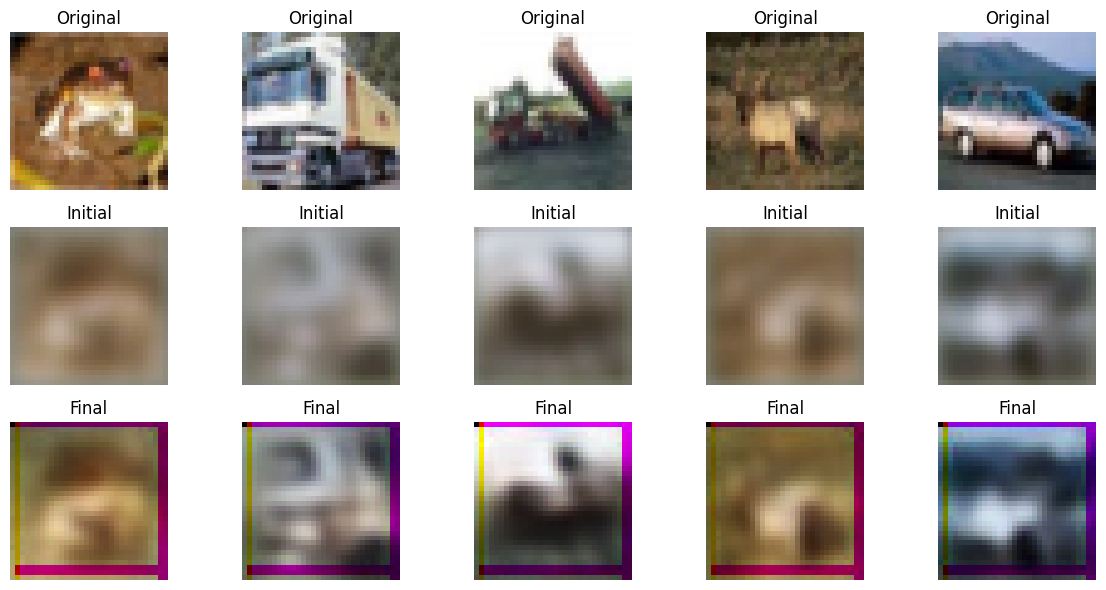

In [ ]:
import matplotlib.pyplot as plt


test_images = image_dataset_norm[:10]


test_signal = model_x(test_images, training=False)


test_received_signal = tf_channel_uwa(test_signal, tf.constant(sigma_sq**0.5, dtype=tf.float32))


reconstructed_images_list = model_receiver(test_received_signal, training=False)
x_initial, x_final = reconstructed_images_list


plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(3, 5, i + 6)
    plt.imshow(x_initial[i])
    plt.title("Initial")
    plt.axis('off')

    plt.subplot(3, 5, i + 11)
    plt.imshow(x_final[i])
    plt.title("Final")
    plt.axis('off')

plt.tight_layout()
plt.show()
